In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler


In [6]:
df_conflits = pd.read_csv("data/brazil_conflicts_dataset.csv")  
df_conflits.info()  

<class 'pandas.core.frame.DataFrame'>
Index: 8331 entries, 279975 to 485414
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8331 non-null   object 
 1   relid              8331 non-null   int64  
 2   year               8331 non-null   bool   
 3   active_year        8331 non-null   object 
 4   code_status        8331 non-null   int64  
 5   type_of_violence   8331 non-null   int64  
 6   conflict_dset_id   8331 non-null   int64  
 7   conflict_new_id    8331 non-null   object 
 8   conflict_name      8331 non-null   int64  
 9   dyad_dset_id       8331 non-null   int64  
 10  dyad_new_id        8331 non-null   object 
 11  dyad_name          8331 non-null   int64  
 12  side_a_dset_id     8331 non-null   int64  
 13  side_a_new_id      8331 non-null   object 
 14  side_a             8331 non-null   int64  
 15  side_b_dset_id     8331 non-null   int64  
 16  side_b_new_id      833

In [7]:
df_conflits.head()

,id,relid,year,active_year,code_status,type_of_violence,conflict_dset_id,conflict_new_id,conflict_name,dyad_dset_id,...,date_prec,date_start,date_end,deaths_a,deaths_b,deaths_civilians,deaths_unknown,best_est,high_est,low_est
279975,BRA-2018-2-15489-47,2018,True,Clear,2,15489,14285,Comando Vermelho - GDE,15489,15489,...,11/01/2018 00:00:00,11/30/2018 00:00:00,0,0,0,9,9,9,9,NaN
279977,BRA-2018-2-15489-48,2018,True,Clear,2,15489,14285,Comando Vermelho - GDE,15489,15489,...,12/01/2018 00:00:00,12/13/2018 00:00:00,0,0,0,6,6,6,6,NaN
279979,BRA-2018-2-15489-49,2018,True,Clear,2,15489,14285,Comando Vermelho - GDE,15489,15489,...,12/12/2018 00:00:00,12/12/2018 00:00:00,0,0,0,2,2,2,2,NaN
279980,BRA-2018-2-15489-50,2018,True,Clear,2,15489,14285,Comando Vermelho - GDE,15489,15489,...,12/05/2018 00:00:00,12/05/2018 00:00:00,0,0,1,0,1,1,1,NaN
279982,BRA-2018-2-15489-59,2018,True,Clear,2,15489,14285,Comando Vermelho - GDE,15489,15489,...,12/05/2018 00:00:00,12/06/2018 00:00:00,0,0,0,3,3,3,3,NaN


## Limpeza de dados

In [8]:
features_numericas = ['year', 'deaths_a', 'deaths_b', 'deaths_civilians', 'deaths_unknown', 'best_est', 'high_est', 'low_est']

features_categoricas = ['type_of_violence', 'date_prec', 'active_year']

In [9]:
# Criando um df para que tudo seja float
df_numerica = df_conflits[features_numericas].apply(pd.to_numeric, errors='coerce').fillna(0)

In [10]:
# Convertendo para string antes do get_dummies para garantir que o pandas consiga tratar como categorias nominais e não como numeros ordiários
df_categoricas = pd.get_dummies(df_conflits[['type_of_violence', 'active_year']].astype(str), prefix='type')

In [11]:
# Criando o DataFrame de modelagem
df_model = df_conflits[df_numerica + df_categoricas].copy().fillna(0)

/var/folders/yb/0t_199hd6xd0c8zshql8663w0000gn/T/ipykernel_62533/590667126.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_model = df_conflits[df_numerica + df_categoricas].copy().fillna(0)


In [12]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8331 entries, 279975 to 485414
Data columns (total 47 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 8331 non-null   int64  
 1   relid              8331 non-null   float64
 2   year               8331 non-null   int64  
 3   active_year        8331 non-null   int64  
 4   code_status        8331 non-null   float64
 5   type_of_violence   8331 non-null   float64
 6   conflict_dset_id   8331 non-null   float64
 7   conflict_new_id    8331 non-null   int64  
 8   conflict_name      8331 non-null   float64
 9   dyad_dset_id       8331 non-null   float64
 10  dyad_new_id        8331 non-null   int64  
 11  dyad_name          8331 non-null   float64
 12  side_a_dset_id     8331 non-null   float64
 13  side_a_new_id      8331 non-null   int64  
 14  side_a             8331 non-null   float64
 15  side_b_dset_id     8331 non-null   float64
 16  side_b_new_id      833

In [13]:
# Escalonamento (Obrigatório para PCA)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_model)

## Redução de dimensionalidade - Comparação entre PCA, UMAP e t-SNE

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
try:
    import umap
    has_umap = True
except ImportError:
    has_umap = False
    print("Dica: Instale o umap-learn usando: pip install umap-learn")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_scaled)

NameError: name 'PCA' is not defined

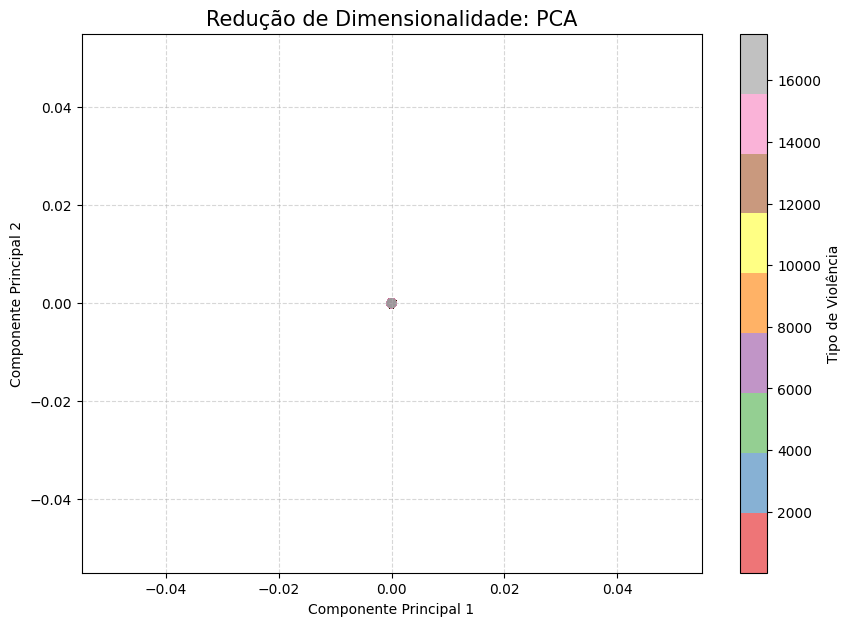

In [13]:
# Plot PCA
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
            c=df_conflits['type_of_violence'], 
            cmap='Set1', alpha=0.6, s=40)

plt.title('Redução de Dimensionalidade: PCA', fontsize=15)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(scatter, label='Tipo de Violência')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [ ]:
# t-SNE (Ajuste a perplexidade se o dataset for pequeno ou grande demais)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(df_scaled)

: 

In [ ]:
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
            c=df_conflits['type_of_violence'], 
            cmap='Set1', alpha=0.6, s=40)

plt.title('Visualização Não-Linear: t-SNE', fontsize=15)
plt.xlabel('Dimensão 1')
plt.ylabel('Dimensão 2')
plt.colorbar(scatter, label='Tipo de Violência')
plt.show()

NameError: name 'plt' is not defined